In [142]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob

In [143]:
masks = xr.open_dataset('data/GLORYS_MASKS.nc')
lon,lat = np.meshgrid(masks.longitude,masks.latitude)
tropicalcoords   = pd.DataFrame((lon[0,:],np.zeros(len(lon[0,:]))), index=['lon','lat']).T
lonn = []
lons = []
for i in range(len(masks.latitude)):
    try:
        x = masks.coastmask_north.where(masks.coastmask_north==1).isel(latitude=i).dropna('longitude')[-1].longitude.item()
        lonn.append(x)
    except:
        lonn.append(np.nan)
        pass
    
    try:
        x = masks.coastmask_south.where(masks.coastmask_south==1).isel(latitude=i).dropna('longitude')[-1].longitude.item()
        lons.append(x)
    except:
        lons.append(np.nan)
        pass
coastnorthcoords = pd.DataFrame((np.array(lonn),lat[:,0]),index=['lon','lat']).T.dropna()
coastsouthcoords = pd.DataFrame((np.array(lons),lat[:,0]),index=['lon','lat']).T.dropna()

coastnorthcoords.index = coastnorthcoords.lat
coastsouthcoords.index = coastsouthcoords.lat

In [144]:
tropical = xr.open_mfdataset('data/GLORYS12V1/HOVMOLLERS/data/tropical/*.nc')
camerica = xr.open_mfdataset('data/GLORYS12V1/HOVMOLLERS/data/camerica/*.nc')
mexico = xr.open_mfdataset('data/GLORYS12V1/HOVMOLLERS/data/mexico/*.nc')
usa = xr.open_mfdataset('data/GLORYS12V1/HOVMOLLERS/data/usa/*.nc')
peru = xr.open_mfdataset('data/GLORYS12V1/HOVMOLLERS/data/peru/*.nc').sortby('latitude', ascending=False)
chile = xr.open_mfdataset('data/GLORYS12V1/HOVMOLLERS/data/chile/*.nc').sortby('latitude', ascending=False)

/home/lucas/miniconda3/envs/forecast/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/lucas/miniconda3/envs/forecast/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array

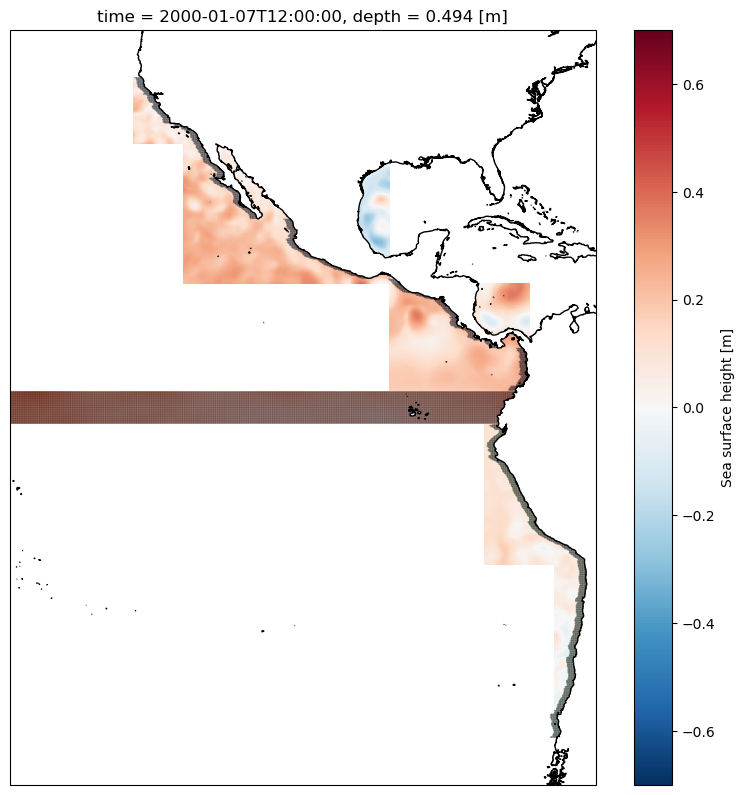

In [145]:
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(10,10), facecolor='w', dpi=100)
ax.set_extent([-140,-69,-40,40])
ax.coastlines('10m')

tropical.zos.sel(time='2000-01-07').plot(ax=ax, cmap='RdBu_r', vmin=-0.7, vmax=0.7, add_colorbar=False)
camerica.zos.sel(time='2000-01-07').plot(ax=ax, cmap='RdBu_r', vmin=-0.7, vmax=0.7, add_colorbar=False)
mexico.zos.sel(time='2000-01-07').plot(ax=ax, cmap='RdBu_r', vmin=-0.7, vmax=0.7, add_colorbar=False)
usa.zos.sel(time='2000-01-07').plot(ax=ax, cmap='RdBu_r', vmin=-0.7, vmax=0.7, add_colorbar=False)
peru.zos.sel(time='2000-01-07').plot(ax=ax, cmap='RdBu_r', vmin=-0.7, vmax=0.7, add_colorbar=False)
chile.zos.sel(time='2000-01-07').plot(ax=ax, cmap='RdBu_r', vmin=-0.7, vmax=0.7, add_colorbar=True)

ax.pcolor(masks.longitude, masks.latitude, masks.tropicalmask.where(masks.tropicalmask), alpha=0.25, cmap='Reds_r', edgecolor='k')
ax.pcolor(masks.longitude, masks.latitude, masks.coastmask_north.where(masks.coastmask_north), alpha=0.25, cmap='Blues_r', edgecolor='k')
ax.pcolor(masks.longitude, masks.latitude, masks.coastmask_south.where(masks.coastmask_south), alpha=0.25, cmap='Greens_r', edgecolor='k')

In [146]:
tropical = tropical.where(masks.tropicalmask==1).mean('latitude').dropna('longitude').load().drop('depth')
tropical = tropical.rename({'longitude':'lon'})


In [147]:

camerica = camerica.where(masks.coastmask_north==1).mean('longitude').dropna('latitude').load().drop('depth')
mexico = mexico.where(masks.coastmask_north==1).mean('longitude').dropna('latitude').load().drop('depth')
usa = usa.where(masks.coastmask_north==1).mean('longitude').dropna('latitude').load().drop('depth')

peru = peru.where(masks.coastmask_south==1).mean('longitude').dropna('latitude').load().drop('depth')
chile = chile.where(masks.coastmask_south==1).mean('longitude').dropna('latitude').load().drop('depth')



In [148]:
coastnorth = xr.concat([camerica, mexico, usa], 'latitude').drop_duplicates('latitude')
coastnorth = coastnorth.rename({'latitude':'lat'})

coastsouth = xr.concat([peru, chile], 'latitude').drop_duplicates('latitude')
coastsouth = coastsouth.sortby('latitude', ascending=False).rename({'latitude':'lat'})

In [149]:
tropical.coords['index']   = ('lon',np.arange(len(tropical.lon)))
coastnorth.coords['index'] = ('lat', 1+tropical.index[-1].item()+np.arange(len(coastnorth.lat)))
coastsouth.coords['index'] = ('lat', 1+tropical.index[-1].item()+np.arange(len(coastsouth.lat)))

In [150]:
tropical = tropical.drop('j').swap_dims({'lon':'index'})
coastnorth = coastnorth.drop('i').swap_dims({'lat':'index'})
coastsouth = coastsouth.drop('i').swap_dims({'lat':'index'})

In [151]:
tropical.coords['lat']    = ('index', np.zeros(len(tropical.lon)))
coastnorth.coords['lon']  = ('index', coastnorthcoords.loc[coastnorth.lat.values].lon.values)
coastsouth.coords['lon']  = ('index', coastsouthcoords.loc[coastsouth.lat.values].lon.values)

In [189]:

def haversine(p1,p2):
    """
    Given two points with lat,lon coordinates, compute the distance
    between those points on the surface of the sphere with the haversine formula
    Args:
        p1 (tuple): first point lat,lon
        p2 (tuple): last point lat,lon

    Returns:
        float: distance
    """
    lat1,lon1 = p1
    lat2,lon2 = p2

    lon1,lon2,lat1,lat2 = map(np.deg2rad, [lon1,lon2,lat1,lat2])

    dlon = lon2-lon1
    dlat = lat2-lat1

    a = np.sin(dlat/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    r = 6371
    return c*r

def distances(data):
    distance = []
    for i in range(len(data.lon.values)-1):
        lon1,lat1 = data.lon.values[i], data.lat.values[i]
        lon2,lat2 = data.lon.values[i+1], data.lat.values[i+1]
        dist = haversine(p1=(lat2,lon2), p2=(lat1,lon1))
        distance.append(dist)
    distance = np.hstack([np.array([0]),np.array(distance)])
    distance = np.cumsum(distance)
    return distance
    
    

In [194]:
tropicaldistance   = distances(tropical)
coastnorthdistance = distances(coastnorth) + tropicaldistance[-1]
coastsouthdistance = distances(coastsouth) + tropicaldistance[-1]
tropical.coords['distance']    = ('index', tropicaldistance)
coastnorth.coords['distance']  = ('index', tropicaldistance[-1]+coastnorthdistance)
coastsouth.coords['distance']  = ('index', tropicaldistance[-1]+coastsouthdistance)

In [197]:
tropical.to_netcdf('data/GLORYS12V1/HOVMOLLERS/glorys_tropical.nc')
coastnorth.to_netcdf('data/GLORYS12V1/HOVMOLLERS/glorys_coastnorth.nc')
coastsouth.to_netcdf('data/GLORYS12V1/HOVMOLLERS/glorys_coastsouth.nc')